<a href="https://colab.research.google.com/github/HRI328/AXA-CASE-1/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [105]:
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# **Unzip Uploaded File**
Transcript_v3.zip file is ready uploaded manually to Google Colab

In [40]:
from zipfile import ZipFile

fileName = "transcripts_v3.zip"

with ZipFile(fileName, 'r') as zip:
    zip.printdir()
    print('Extracting all the files now...')
    for file in zip.namelist():
      zip.extractall()
    print('Done')

File Name                                             Modified             Size
manifest.mf                                    2024-10-11 07:08:44          101
transcripts_v3/                                2024-10-11 07:08:44           98
transcripts_v3/transcript_0.txt                2024-10-11 07:08:44         2298
transcripts_v3/transcript_1.txt                2024-10-11 07:08:44         1915
transcripts_v3/transcript_2.txt                2024-10-11 07:08:44         2021
transcripts_v3/transcript_3.txt                2024-10-11 07:08:44         2572
transcripts_v3/transcript_4.txt                2024-10-11 07:08:44         1537
transcripts_v3/transcript_5.txt                2024-10-11 07:08:44         2425
transcripts_v3/transcript_6.txt                2024-10-11 07:08:44         2209
transcripts_v3/transcript_7.txt                2024-10-11 07:08:44         2062
transcripts_v3/transcript_8.txt                2024-10-11 07:08:44         2670
transcripts_v3/transcript_9.txt         

# **Input Data to Google Colab and Overview**

The transcripts_v3.zip data file has been unzipped into transcripts_v3 folder. Here the unzipped text data is inputted into Googl Colab to have a look.
The result shows this data file has total 200 text message without label. The test message has punctuation and "\n".

In [207]:
text_all = []
for i in range(200):
  file = open("transcripts_v3/transcript_"+str(i)+".txt", "r")
  test_1 = file.read()
  text_all.append(test_1)
  file.close

print(f"Number of text message is : {len(text_all)}")
print(text_all[0])


Number of text message is : 200
Member: Hi, I'm calling to get a case pre-authorized. My name is Emily Wilson and my member ID is MEM456789.

PA Agent: Hi Emily, thank you for calling PA customer care. Can you please confirm your date of birth for verification purposes?

Member: It's March 12, 1985.

PA Agent: Thank you, Emily. Can you please provide me with some details about the case you're seeking pre-authorization for? What's the nature of the treatment or service you're looking to receive?

Member: I'm scheduled to undergo an MRI scan for a knee injury. My doctor's office has already submitted the request, but I wanted to confirm the status and ensure that it's covered under my plan.

PA Agent: I apologize for the delay, Emily. Let me just check on the status of your request. Can you please hold for just a moment?

Member: Sure, thank you.

PA Agent: Thank you for holding, Emily. I've located your request and I'm reviewing the details now. Can you please confirm the name of your d

# **Extract Customer Information**

In [145]:
customer_list = []
for i in range(200):
  customer = list(filter(lambda x: 'member' in x.lower(), text_all[i].split('\n')))
  customer_list.append(' '.join(customer))


# **Standardize Text Message**
Convert all character into lower case and replace all special characters by space, replace multiple space by single space.

In [163]:
def standard_text(inputText):
  # This function is used to standardize the text massage
  # inputText : test string
  # return : tensor
  inputText_low = tf.strings.lower(inputText)
  inputText_low1 = tf.strings.regex_replace(inputText_low, '[^a-z0-9 ]', ' ')
  inputText_low2 = tf.strings.regex_replace(inputText_low1, ' +', ' ')
  return tf.strings.regex_replace(inputText_low2, '[%s]' % re.escape(string.punctuation), '')


In [164]:
# Test the standardize text function
standard_text(customer_list[2])

<tf.Tensor: shape=(), dtype=string, numpy=b'member hi i m calling about my recent doctor s visit i was charged a copay of 50 but i thought my policy covered that service with a 20 copay customer support i apologize for the inconvenience mr johnson can you please provide me with your member id so i can look into this further member it s mem456789 member it was on february 10th and it was a routine physical exam member yeah because my policy says that routine physical exams have a 20 copay or sometimes no copay at all member okay that sounds good how long will it take to resolve this member alright that sounds good can i get a reference number for the case member okay got it thank you for your help member alright thanks member no that s all member you too thanks '>

In [168]:
# maximum number of words set
max_features = 1100
# text sentence could include maximum word
sequence_length = 400

# Vectorization of text message
vectorize_layer = layers.TextVectorization(
    standardize=standard_text,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(customer_list)

In [169]:
# Make text vectorization
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)

In [170]:
# Random vocabulary check
print("0 to 9 ----->", vectorize_layer.get_vocabulary()[:10])
print("20 to 29 ----->", vectorize_layer.get_vocabulary()[20:30])
print("300 to 309 ----->", vectorize_layer.get_vocabulary()[300:310])
print("1000 to 1009 ----->", vectorize_layer.get_vocabulary()[1000:1010])
print("Vaocabulary size : {}".format(len(vectorize_layer.get_vocabulary())))

0 to 9 -----> ['', '[UNK]', 'member', 'i', 'my', 'you', 'that', 'to', 'is', 'the']
20 to 29 -----> ['but', 'can', 'was', 'id', 'in', 'no', 'hi', 'policy', 'sounds', 'all']
300 to 309 -----> ['we', 'update', 'told', 'them', 'ridiculous', 'reprocess', 'plan', 'orthopedic', 'multiple', 'mr']
1000 to 1009 -----> ['8', '76700', '73600', '715', '654321', '6', '5555', '500', '5', '4219']
Vaocabulary size : 1023


# **Embedding**

In [171]:
embedding = Embedding(input_dim=max_features, output_dim=16)

customer_list_embedding = embedding(vectorize_layer(customer_list))

In [172]:
# check the shape of the embedding
customer_list_embedding.shape

TensorShape([200, 400, 16])

In [173]:
# Check embedding
customer_list_embedding[0, 0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 0.02256527, -0.01015963, -0.0134517 , -0.04695266,  0.02395989,
        0.02997326, -0.02799593,  0.04342672, -0.01042522,  0.01506963,
        0.00218891,  0.04749424, -0.04297661, -0.01693338,  0.03743874,
        0.01172577], dtype=float32)>

In [174]:
# Reshape the data to 2D by averaging the embedding for each document
customer_list_embedding_2d = tf.reduce_mean(customer_list_embedding, axis=1).numpy()
customer_list_embedding_2d.shape



(200, 16)

# **Using K-mean to Clusterring**
The text message has not been labelled. So unsupervised machine learning is used. Here k-mean is used.
The reason is:
     
*   Simple: easy to understand and implement.
*   Efficient: fast compared to other clustering algorithms.
*   Interpretable: easy to understand and can help derive insights.


In [200]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# set number of clusters as 3 to corresponding to Positive, Negative, and Neutral
kmeans = KMeans(n_clusters=3,
                tol=.0001,
                max_iter=15,
                random_state=0)
label = kmeans.fit_predict(customer_list_embedding_2d)


# **Convert Text Message into Dataframe and Attaching Label Identified**

In [189]:
customer_text_df = pd.DataFrame(customer_list, columns=['text'])
customer_text_df['label'] = label

,text,label
50,"Member: Hi, I'm calling about my recent copay ...",0
51,"Member: Hi, I'm calling about my recent bill f...",0
52,"Member: Hi, I'm calling to schedule an appoint...",1
53,"Member: Hi, I'm having trouble registering and...",0
54,"Member: Hi, I'm calling to get a case pre-auth...",1
55,"Member: Hi, I'm calling about a denied claim I...",0
56,"Member: Hi, I'm calling to get a case pre-auth...",2
57,"Member: Hi, I'm calling about my recent doctor...",1
58,"Member: Hi, I'm calling to request a pre-autho...",1
59,"Member: Hi, I'm calling to get a case pre-auth...",1


# **Select some text message to identify the physical meaning of the label **

In [201]:
# customer_text_df.loc[20:25]
# customer_list[0]     #'0: resolved'
# customer_list[7]   1: Follow up
# customer_list[5]     2: Follow
# customer_list[3]       #2: Not sure
# customer_list[9]      0: resolved
# customer_list[26]   1: Follow up
# customer_list[22]     0 : resolved
# customer_list[23]     1: Follow up
# customer_list[21]     2: resolved
# customer_list[56]      2: Follow up

In [192]:
# Attach label meaning to dataframe and display top 5 text message
label_dic = {0 : "Resolved", 1: "Follow up", 2: "Mixed"}
customer_text_df['labelMeaning'] = customer_text_df['label'].map(label_dic)
customer_text_df.head()

,text,label,labelMeaning
0,"Member: Hi, I'm calling to get a case pre-auth...",0,Resolved
1,"Member: Hi, I'm calling about a denied claim I...",1,Follow up
2,"Member: Hi, I'm calling about my recent doctor...",0,Resolved
3,"Member: Hi, I'm calling about my recent visit ...",2,Mixed
4,"Member: Hi, I'd like to schedule an appointmen...",1,Follow up


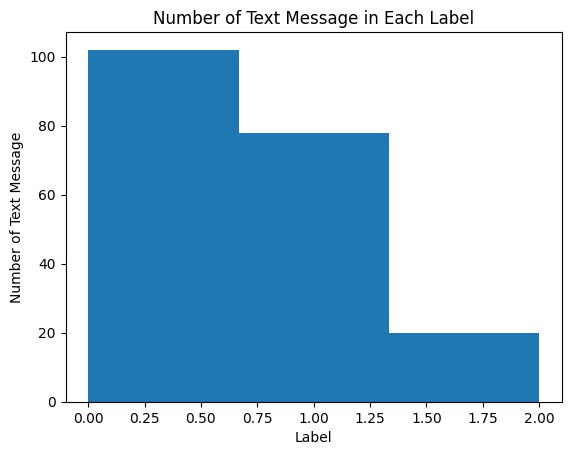

In [208]:
# Show number of test message in each label
from matplotlib import pyplot as plt
customer_text_df['label'].plot(kind='hist', bins=3, title='Number of Text Message in Each Label')
plt.xlabel('Label')
plt.ylabel('Number of Text Message')
plt.show()
# plt.gca().spines[['top', 'right',]].set_visible(False)

# Accuracy Check

PCA transformation to see the label identified by k-means.
From PCA variance ratio, we could see the first two pricenpal components include over 90% information in the embeeding generated from the test message. Here the scatter plot from the first two PCA components colored by the label identified clearly shows the label with the high accuracy because three groups are clearly separated.

PCA Variance Ratio : [0.8589899  0.03151062]



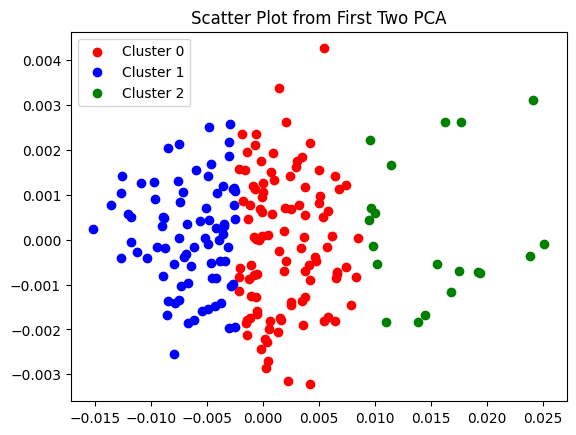

In [210]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

customer_list_embedding_2d_pca = pca.fit_transform(customer_list_embedding_2d)

print(f"PCA Variance Ratio : {pca.explained_variance_ratio_}\n")

class0 = customer_list_embedding_2d_pca[label == 0]
class1 = customer_list_embedding_2d_pca[label == 1]
class2 = customer_list_embedding_2d_pca[label == 2]
plt.scatter(class0[:, 0], class0[:, 1], c='red', label='Cluster 0')
plt.scatter(class1[:, 0], class1[:, 1], c='blue', label='Cluster 1')
plt.scatter(class2[:, 0], class2[:, 1], c='green', label='Cluster 2')
plt.title('Scatter Plot from First Two PCA')
plt.legend()
plt.show()


# **Scatter Plot from Average Embedding**

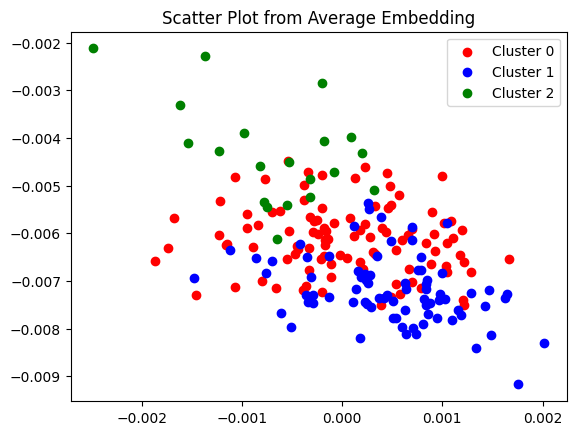

In [204]:
class0 = customer_list_embedding_2d[label == 0]
class1 = customer_list_embedding_2d[label == 1]
class2 = customer_list_embedding_2d[label == 2]
plt.scatter(class0[:, 0], class0[:, 1], c='red', label='Cluster 0')
plt.scatter(class1[:, 0], class1[:, 1], c='blue', label='Cluster 1')
plt.scatter(class2[:, 0], class2[:, 1], c='green', label='Cluster 2')
plt.title('Scatter Plot from Average Embedding')
plt.legend()
plt.show()